# Проект: Оптимизация производственных расходов металлургического комбината

## Описание задачи
<b> Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

1. Подготовка данных
- загрузить библиотеки
- загрузить таблицы и просмотреть каждую из них
- проверить на аномалии(пропуски, дубликаты, выбросы)
- проверить форматы в столбцах
- построить гистограммы

## Обучение моделей

Поделить выборку на тренировочную и тестовую в соотношении 25/75 провести масштабирование данных количественных признаков обучить несколько моделей на тренировочной выборке и выбрать модель для проверки на test (использовать два вида моделей :1. Линейную (любую) и 2. Градиентный бустинг (любую).

## Вывод:

<div class="alert alert-info">
Представленная модель может быть использована для оптимизации производственных расходов металлургического комбината ООО «Так закаляем сталь»

## Подготовка данных

In [55]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore') 
RND = 100423

In [2]:
arc = pd.read_csv('data_arc_new.csv')
bulk = pd.read_csv('data_bulk_new.csv')
bulk_time = pd.read_csv('data_bulk_time_new.csv')
gas = pd.read_csv('data_gas_new.csv')
temp = pd.read_csv('data_temp_new.csv')
wire = pd.read_csv('data_wire_new.csv')
wire_time = pd.read_csv('data_wire_time_new.csv')

<b> Таблица data_arc.csv — данные об электродах

In [3]:
# оптимизирую и создаю функцию
# использую display чтобы выводы были более читаемыми
def select_pd(pd):
    display(pd.head(5))
    display(pd.info())
    display(pd.describe())
    display(pd.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'))
    #создаю и отображаю график, который показывает процент пропущенных значений в каждом столбце DataFrame. #
    display(pd.duplicated().sum())

In [4]:
select_pd(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


,0
key,0.00%
Начало нагрева дугой,0.00%
Конец нагрева дугой,0.00%
Активная мощность,0.00%
Реактивная мощность,0.00%


0

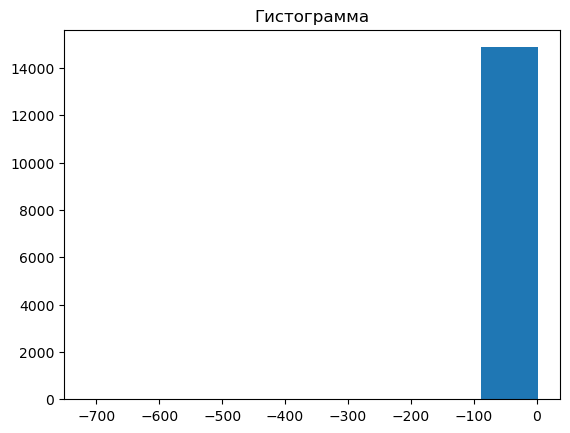

In [5]:
plt.hist(arc['Реактивная мощность'], bins=8)
plt.title('Гистограмма')
plt.show()

# Вывод по таблице

У реактивной мощности отрицательные значения. По условиям задания в предобработке их уберем.
Столбцы "Начало нагрева дугой" и "Конец нагрева дугой" перевожу в тип Datetime
Можно создать на основе этой таблицы два признака. а) кпд = активная мощность - реактивная мощность б) полная мощность = корень из суммы квадратов активной и реактивной мощностей.

In [6]:
select_pd(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,0
key,0.00%
Bulk 14,10.32%
Bulk 12,21.70%
Bulk 15,28.16%
Bulk 3,58.52%
Bulk 4,67.59%
Bulk 6,81.59%
Bulk 1,91.95%
Bulk 11,94.34%
Bulk 10,94.38%


0

<b> Вывод по таблице
    
    Огромное количество пропущенных значений. Поменяю значения Nan на 0

In [7]:
select_pd(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,0
key,0.00%
Bulk 14,10.32%
Bulk 12,21.70%
Bulk 15,28.16%
Bulk 3,58.52%
Bulk 4,67.59%
Bulk 6,81.59%
Bulk 1,91.95%
Bulk 11,94.34%
Bulk 10,94.38%


0

<b> Вывод по таблице
    
    Огромное количество пропущенных значений. Можно не использовать в моделировании.

In [8]:
select_pd(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,0
key,0.00%
Wire 1,0.84%
Wire 2,64.98%
Wire 6,97.63%
Wire 3,97.96%
Wire 9,99.06%
Wire 8,99.38%
Wire 4,99.55%
Wire 7,99.64%
Wire 5,99.97%


0

<b>  Вывод по таблице

     Огромное количество пропущенных значений. Эту таблицу не использую в моделировании.

In [9]:
select_pd(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,0
key,0.00%
Газ 1,0.00%


0

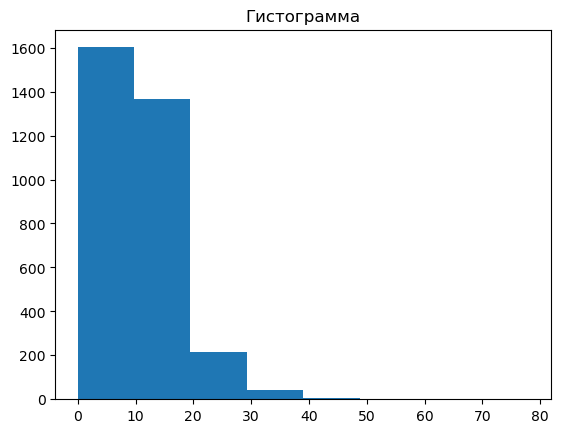

In [10]:
plt.hist(gas['Газ 1'], bins=8)
plt.title('Гистограмма')
plt.show()

<b> Вывод по таблице
    
    Пропуски и нулевых значений нет. Ести выбросы.

In [11]:
select_pd(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


,0
key,0.00%
Время замера,0.00%
Температура,18.94%


0

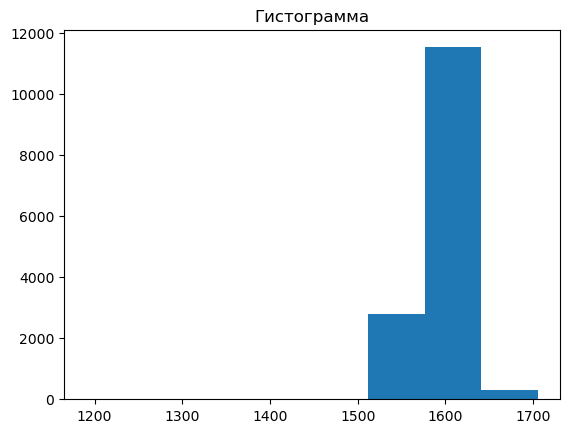

In [12]:
plt.hist(temp['Температура'], bins=8)
plt.title('Гистограмма')
plt.show()

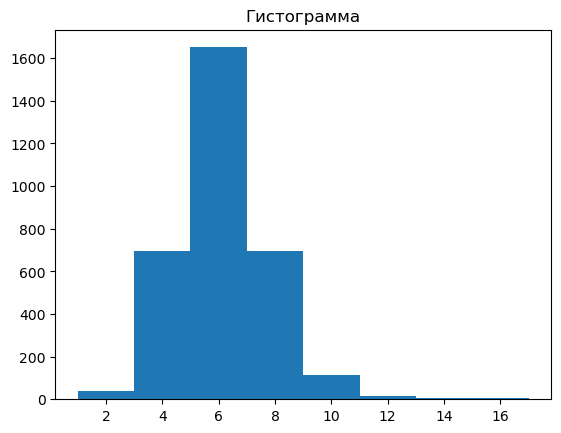

In [13]:
plt.hist((temp['key']).value_counts(), bins=8)
plt.title('Гистограмма')
plt.show()

<b>  Вывод по таблице
    
1. По условиям задания убираю значения температуры ниже 1500 градусов.
2. Столбцы "Время замера" преобразую в тип Datetime
3. Меняю пропуски на 0

In [14]:
select_pd(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,0
key,0.00%
Wire 1,0.84%
Wire 2,64.98%
Wire 6,97.63%
Wire 3,97.96%
Wire 9,99.06%
Wire 8,99.38%
Wire 4,99.55%
Wire 7,99.64%
Wire 5,99.97%


0

<b> Вывод по таблице

Заменим пропуски на 0
На каждую партию приходится несколько замеров температуры. Есть партии, где замеров меньше двух. 
По условиям задания эти партии в моделировании не рассматриваю.

## Предобработка данных

 - обработать пропуски и значения Nan (заменить на 0)

 - обработать форматы данных (в таблицах со столбцами с датами заменить тип данных на DateTime)

 - понять, как связаны таблицы между собой проверить на мультиколлинеарность

 - объединить таблицы по столбцу key

 - целевой признак финальная температура

 - нецелевые признаки (кпд, полная мощность)

 - исползовать метрику(MAE). В данном проекте MAE д.б. меньше 6,8.

<b> Замена значения Nan на 0 в таблицах

In [15]:
bulk = bulk.fillna(0)
temp = temp.fillna(0)
wire = wire.fillna(0)

In [16]:
 display(bulk.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'))

,0
key,0.00%
Bulk 1,0.00%
Bulk 2,0.00%
Bulk 3,0.00%
Bulk 4,0.00%
Bulk 5,0.00%
Bulk 6,0.00%
Bulk 7,0.00%
Bulk 8,0.00%
Bulk 9,0.00%


In [17]:
display(temp.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'))

,0
key,0.00%
Время замера,0.00%
Температура,0.00%


In [18]:
display(wire.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'))

,0
key,0.00%
Wire 1,0.00%
Wire 2,0.00%
Wire 3,0.00%
Wire 4,0.00%
Wire 5,0.00%
Wire 6,0.00%
Wire 7,0.00%
Wire 8,0.00%
Wire 9,0.00%


<b> Обработка формата данных (столбцы с датами меняю тип данных на DateTime)

In [19]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')  
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S') 
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%dT%H:%M:%S') 

<b> согласно задания удаляю значения температуры ниже 1500 градусов в таблице temp

In [20]:
temp = temp.loc[(temp['key'] >= 1500)] 
temp.describe()

,key,Температура
count,9711.000000,9711.000000
mean,2366.195345,1028.586860
std,502.253593,759.836589
min,1500.000000,0.000000
25%,1930.000000,0.000000
50%,2368.000000,1576.000000
75%,2801.000000,1593.000000
max,3241.000000,1696.000000


<b> У реактивной мощности в таблице arc отрицательные значения. Согласно задания в предобработке их надо убрать.

In [21]:
arc = arc.loc[(arc['Реактивная мощность'] > 0)]
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


<b> Создаю на основе таблицы arc два признака. а) кпд = активная мощность - реактивная мощность б) полная мощность = корень из суммы квадратов активной и реактивной мощностей.

In [22]:
arc['efficiency'] = arc['Активная мощность']-arc['Реактивная мощность']
arc['full power'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)
arc.describe()

,key,Активная мощность,Реактивная мощность,efficiency,full power
count,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115,0.175634,0.823385
std,934.593897,0.258894,0.197612,0.084830,0.323470
min,1.000000,0.223120,0.153777,0.000404,0.275718
25%,806.000000,0.467115,0.337190,0.113946,0.578839
50%,1617.000000,0.599578,0.441665,0.159585,0.746554
75%,2429.000000,0.830135,0.608223,0.222914,1.030402
max,3241.000000,1.463773,1.270284,0.550698,1.898158


<b> Проверка признаков на мультиколлинеарность
    
(Мультиколлинеарность - это ситуация, когда несколько признаков в данных сильно коррелируют друг с другом)

In [23]:
# Метод corr() в библиотеке pandas используется для вычисления корреляции между столбцами в DataFrame
display(arc[['Активная мощность', 'Реактивная мощность','efficiency', 'full power','key']].corr())

,Активная мощность,Реактивная мощность,efficiency,full power,key
Активная мощность,1.000000,0.966373,0.800736,0.995527,-0.010226
Реактивная мощность,0.966373,1.000000,0.619777,0.986330,-0.013169
efficiency,0.800736,0.619777,1.000000,0.740594,-0.000531
full power,0.995527,0.986330,0.740594,1.000000,-0.011348
key,-0.010226,-0.013169,-0.000531,-0.011348,1.000000


<b> Сильная корелляция между активной и реактивной мощностями. Не буду использовать эти признаки при обучении модели, чтобы избежать переобучения. У ~key~ отрицательные значения, не будем использовать их при обучении модели.

In [24]:
arc_count = arc.groupby(by = 'key', as_index=False).count()[['key','Начало нагрева дугой']]
arc = arc.groupby(by = 'key', as_index = False).sum()
arc = arc.merge(arc_count, how='left', on='key') # объединяю два DataFrame по столбцу 'key'

In [25]:
arc = arc[['key', 'full power']]
arc.columns # создаю список, содержащий имена 2 столбцов 'key' и 'full power'

Index(['key', 'full power'], dtype='object')

In [26]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3214 non-null   int64  
 1   full power  3214 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.3 KB


In [27]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9711 entries, 8381 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           9711 non-null   int64         
 1   Время замера  9711 non-null   datetime64[ns]
 2   Температура   9711 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 303.5 KB


In [28]:
# получаю первые и последние значения в каждой группе данных, потом метод reset_index() удаляет текущий индекси заменяет его новым индексом, который начинается с 0.
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()

In [29]:
temp.columns = temp.columns.droplevel()  # удаляю первый уровень из MultiIndex для столбцов
temp.head()

,,first,last,first,last
0,1500,2019-06-28 19:52:30,2019-06-28 20:45:54,1596.0,1597.0
1,1501,2019-06-28 20:56:46,2019-06-28 21:26:51,1578.0,1595.0
2,1502,2019-06-28 21:28:44,2019-06-28 22:02:22,1556.0,1601.0
3,1503,2019-06-28 22:07:29,2019-06-28 22:43:17,1525.0,1580.0
4,1504,2019-06-28 22:47:21,2019-06-28 23:15:39,1545.0,1568.0


In [30]:
temp.columns = ['key', 'first', 'last', 'first temp', 'last temp']
temp.head()

,key,first,last,first temp,last temp
0,1500,2019-06-28 19:52:30,2019-06-28 20:45:54,1596.0,1597.0
1,1501,2019-06-28 20:56:46,2019-06-28 21:26:51,1578.0,1595.0
2,1502,2019-06-28 21:28:44,2019-06-28 22:02:22,1556.0,1601.0
3,1503,2019-06-28 22:07:29,2019-06-28 22:43:17,1525.0,1580.0
4,1504,2019-06-28 22:47:21,2019-06-28 23:15:39,1545.0,1568.0


In [31]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731 entries, 0 to 1730
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         1731 non-null   int64         
 1   first       1731 non-null   datetime64[ns]
 2   last        1731 non-null   datetime64[ns]
 3   first temp  1731 non-null   float64       
 4   last temp   1731 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 67.7 KB


In [32]:
temp = temp[['key', 'first temp', 'last temp']]
temp.columns

Index(['key', 'first temp', 'last temp'], dtype='object')

In [33]:
temp['key'].unique()

array([1500, 1501, 1502, ..., 3239, 3240, 3241], dtype=int64)

In [34]:
temp = temp.loc[(temp['first temp'] >0)]

In [35]:
temp = temp.loc[(temp['last temp'] >0)]

In [36]:
temp['key'].unique()

array([1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510,
       1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521,
       1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532,
       1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543,
       1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554,
       1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565,
       1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576,
       1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587,
       1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598,
       1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609,
       1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620,
       1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631,
       1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642,
       1643, 1644, 1645, 1646, 1647, 1648, 1649, 16

In [37]:
temp['last temp'].unique()

array([1597., 1595., 1601., 1580., 1568., 1629., 1581., 1570., 1574.,
       1577., 1593., 1605., 1612., 1590., 1604., 1600., 1584., 1587.,
       1628., 1681., 1646., 1661., 1641., 1578., 1585., 1579., 1575.,
       1583., 1591., 1589., 1596., 1602., 1623., 1598., 1599., 1592.,
       1588., 1616., 1594., 1653., 1676., 1658., 1606., 1610., 1586.,
       1582., 1621., 1569., 1573., 1576., 1572., 1617., 1611., 1613.,
       1603., 1614., 1620., 1624., 1655., 1652., 1640., 1618., 1619.,
       1622., 1607., 1633., 1696., 1671., 1615., 1608., 1554., 1566.,
       1550., 1609., 1626., 1545., 1543., 1541., 1556., 1551., 1680.,
       1648., 1649., 1647., 1644., 1643., 1684., 1650.])

In [38]:
temp['first temp'].unique()

array([1596., 1578., 1556., 1525., 1545., 1640., 1572., 1592., 1563.,
       1573., 1574., 1559., 1568., 1553., 1595., 1591., 1615., 1535.,
       1598., 1566., 1584., 1642., 1587., 1630., 1639., 1644., 1602.,
       1561., 1536., 1633., 1612., 1562., 1558., 1571., 1565., 1597.,
       1580., 1605., 1590., 1569., 1583., 1624., 1601., 1609., 1554.,
       1616., 1614., 1603., 1611., 1628., 1629., 1637., 1638., 1625.,
       1622., 1577., 1575., 1570., 1567., 1543., 1579., 1621., 1531.,
       1576., 1585., 1606., 1582., 1594., 1541., 1547., 1560., 1581.,
       1550., 1548., 1586., 1218., 1546., 1564., 1610., 1607., 1539.,
       1589., 1551., 1608., 1555., 1530., 1519., 1526., 1613., 1532.,
       1538., 1534., 1533., 1600., 1647., 1593., 1588., 1635., 1661.,
       1645., 1649., 1599., 1557., 1620., 1604., 1623., 1654., 1658.,
       1632., 1634., 1627., 1618., 1617., 1631., 1641., 1636., 1619.,
       1540., 1527., 1652., 1650., 1660., 1227., 1552., 1528., 1549.,
       1646., 1542.,

In [39]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992 entries, 0 to 991
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         992 non-null    int64  
 1   first temp  992 non-null    float64
 2   last temp   992 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 31.0 KB


<b> Соединяю данные в одну таблицу по столбцу key. Беру таблицы arc, temp, bulk, wire

In [40]:
data = arc.merge(temp, how ='left', on ='key')
data = data.merge(bulk, how ='left', on ='key')
data = data.merge(wire, how ='left', on ='key')
data = data.merge(gas, how ='left', on ='key')

In [41]:
data.head()

,key,full power,first temp,last temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,3.718736,NaN,NaN,0.0,0.0,0.0,43.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,2.588349,NaN,NaN,0.0,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,5.019223,NaN,NaN,0.0,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,3.400038,NaN,NaN,0.0,0.0,0.0,81.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,2.816980,NaN,NaN,0.0,0.0,0.0,78.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3214 non-null   int64  
 1   full power  3214 non-null   float64
 2   first temp  992 non-null    float64
 3   last temp   992 non-null    float64
 4   Bulk 1      3128 non-null   float64
 5   Bulk 2      3128 non-null   float64
 6   Bulk 3      3128 non-null   float64
 7   Bulk 4      3128 non-null   float64
 8   Bulk 5      3128 non-null   float64
 9   Bulk 6      3128 non-null   float64
 10  Bulk 7      3128 non-null   float64
 11  Bulk 8      3128 non-null   float64
 12  Bulk 9      3128 non-null   float64
 13  Bulk 10     3128 non-null   float64
 14  Bulk 11     3128 non-null   float64
 15  Bulk 12     3128 non-null   float64
 16  Bulk 13     3128 non-null   float64
 17  Bulk 14     3128 non-null   float64
 18  Bulk 15     3128 non-null   float64
 19  Wire 1      3080 non-null  

In [43]:
data = data.rename(columns={'Газ 1': 'Gas'})
data = data.loc[(data['first temp'] >1500)]
data = data.loc[(data['last temp'] >1500)]

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 1483 to 2474
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         990 non-null    int64  
 1   full power  990 non-null    float64
 2   first temp  990 non-null    float64
 3   last temp   990 non-null    float64
 4   Bulk 1      960 non-null    float64
 5   Bulk 2      960 non-null    float64
 6   Bulk 3      960 non-null    float64
 7   Bulk 4      960 non-null    float64
 8   Bulk 5      960 non-null    float64
 9   Bulk 6      960 non-null    float64
 10  Bulk 7      960 non-null    float64
 11  Bulk 8      960 non-null    float64
 12  Bulk 9      960 non-null    float64
 13  Bulk 10     960 non-null    float64
 14  Bulk 11     960 non-null    float64
 15  Bulk 12     960 non-null    float64
 16  Bulk 13     960 non-null    float64
 17  Bulk 14     960 non-null    float64
 18  Bulk 15     960 non-null    float64
 19  Wire 1      943 non-null 

In [45]:
data = data.drop(['key'], axis = 1)
data = data.dropna() # удаляю строки с пропущенными значениями

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925 entries, 1483 to 2474
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full power  925 non-null    float64
 1   first temp  925 non-null    float64
 2   last temp   925 non-null    float64
 3   Bulk 1      925 non-null    float64
 4   Bulk 2      925 non-null    float64
 5   Bulk 3      925 non-null    float64
 6   Bulk 4      925 non-null    float64
 7   Bulk 5      925 non-null    float64
 8   Bulk 6      925 non-null    float64
 9   Bulk 7      925 non-null    float64
 10  Bulk 8      925 non-null    float64
 11  Bulk 9      925 non-null    float64
 12  Bulk 10     925 non-null    float64
 13  Bulk 11     925 non-null    float64
 14  Bulk 12     925 non-null    float64
 15  Bulk 13     925 non-null    float64
 16  Bulk 14     925 non-null    float64
 17  Bulk 15     925 non-null    float64
 18  Wire 1      925 non-null    float64
 19  Wire 2      925 non-null 

In [47]:
data.head(5)

,full power,first temp,last temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Gas
1483,4.946806,1596.0,1597.0,46.0,0.0,0.0,203.0,0.0,0.0,0.0,...,114.145203,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.685625
1484,4.014354,1578.0,1595.0,0.0,0.0,0.0,239.0,0.0,0.0,0.0,...,61.073998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.872583
1485,5.788610,1556.0,1601.0,0.0,0.0,51.0,0.0,0.0,165.0,0.0,...,82.040405,60.199360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.384768
1486,4.824101,1525.0,1580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65.051994,30.129841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.652141
1487,3.383646,1545.0,1568.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,78.062401,56.791281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.607781


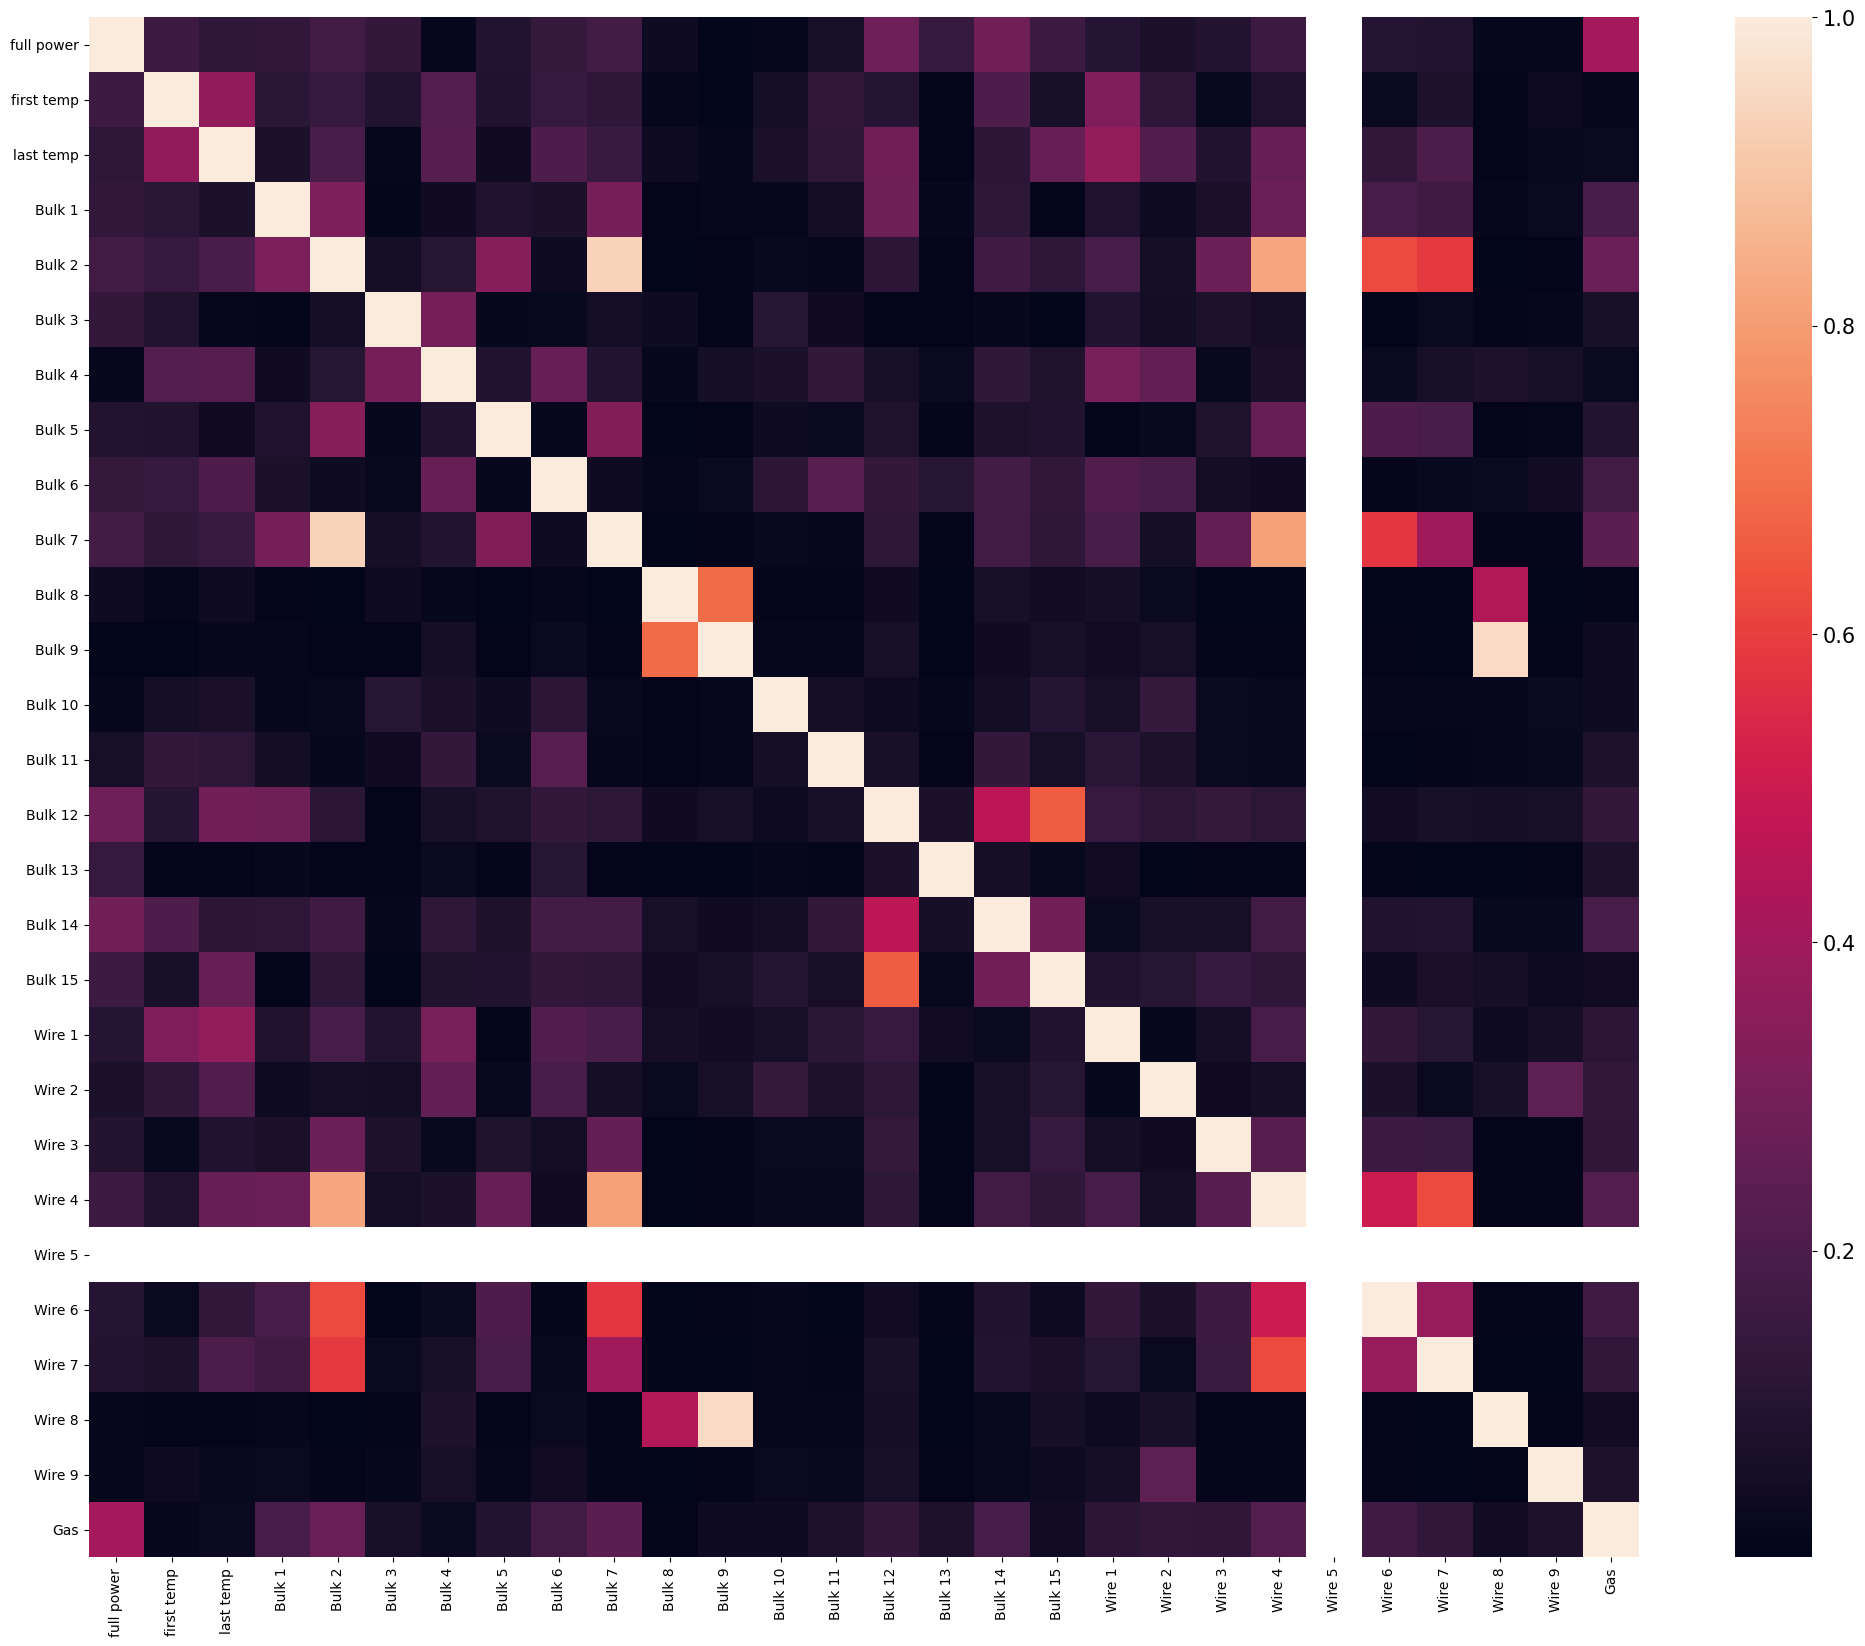

In [48]:
corr = abs(data.corr()) # вычисляю абсолютное значение корреляции между столбцами 

f, ax = plt.subplots(figsize=(25, 20)) # создаю новую фигуру с заданными размерами и сохраняю ссылки на фигуру и ось в переменных f и ax

font = {'size': 15} # устанавливаю размер шрифта равным 15 пунктам
plt.rc('font', **font)


cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(corr, xticklabels=True, yticklabels=True)

<b>  у wire5 нет значений - удаляю

In [49]:
target = data['last temp']
features = data.drop('last temp', axis = 1)

In [50]:
target_train,target_test, features_train, features_test = train_test_split(target,features, test_size = 0.25, random_state = RND)

# Обучение моделей

<b> LinearRegression()

In [51]:
pip install ipython

Note: you may need to restart the kernel to use updated packages.


In [62]:
from sklearn.linear_model import LinearRegression
import numpy as np
model = sklearn.linear_model.LinearRegression()
%time
Line_params = {'fit_intercept':[True,False], 'normalize':[True, False]}

Line_grid = GridSearchCV(LinearRegression(), param_grid = Line_params,  scoring='neg_mean_absolute_error', cv=5)
Line_m = Line_grid.fit(features_train, target_train)
print(f'Лучшая MSE: {-Line_m.best_score_} при параметрах {Line_m.best_params_}')

Wall time: 0 ns
Лучшая MSE: 7.0396091943357835 при параметрах {'fit_intercept': True, 'normalize': False}


<b> CatBoostRegressor

In [60]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [61]:
from catboost import CatBoostRegressor
import numpy as np
model = catboost.CatBoostRegressor()

%time
cat_params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [2, 5, 7]
             }
cat_grid = GridSearchCV(CatBoostRegressor(), param_grid = cat_params, scoring='neg_mean_absolute_error', cv=5)
cat_m = cat_grid.fit(features_train, target_train)

print(f'Лучшая MAE: {-cat_m.best_score_} при параметрах {cat_m.best_params_}')


Wall time: 0 ns
Лучшая MAE: 6.6024831806555895 при параметрах {'max_depth': 7, 'n_estimators': 50, 'random_state': 100423, 'verbose': 0}


<b> Лучший результат на обучающей выборке у модели CatBoostRegressor. Проверим ее на тестовой выборке.

In [66]:
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

MAE_cat = -cross_val_score(CatBoostRegressor(), features_train, target_train, scoring='neg_mean_absolute_error', cv=5).mean() 
print(MAE_cat)

Learning rate set to 0.037295
0:	learn: 11.4162297	total: 7.96ms	remaining: 7.95s
1:	learn: 11.3176092	total: 13.7ms	remaining: 6.85s
2:	learn: 11.1935560	total: 19.6ms	remaining: 6.51s
3:	learn: 11.1015866	total: 25.1ms	remaining: 6.25s
4:	learn: 11.0158006	total: 30.9ms	remaining: 6.15s
5:	learn: 10.9282457	total: 40.5ms	remaining: 6.71s
6:	learn: 10.8228564	total: 44.6ms	remaining: 6.33s
7:	learn: 10.7354201	total: 49.9ms	remaining: 6.18s
8:	learn: 10.6423962	total: 54.6ms	remaining: 6.01s
9:	learn: 10.5491798	total: 58.2ms	remaining: 5.76s
10:	learn: 10.4690943	total: 61.5ms	remaining: 5.53s
11:	learn: 10.4047370	total: 65.4ms	remaining: 5.38s
12:	learn: 10.3227807	total: 69ms	remaining: 5.24s
13:	learn: 10.2190430	total: 72.4ms	remaining: 5.1s
14:	learn: 10.1212603	total: 75.7ms	remaining: 4.97s
15:	learn: 10.0391873	total: 79.2ms	remaining: 4.87s
16:	learn: 9.9477453	total: 82.8ms	remaining: 4.79s
17:	learn: 9.8681098	total: 86.5ms	remaining: 4.72s
18:	learn: 9.7826940	total: 89.

In [67]:
params_cat = cat_grid.best_params_
cat = CatBoostRegressor(**params_cat)
cat.fit(features_train, target_train)
pred_test = cat.predict(features_test)
print(params_cat)
print("MAE on test: ", mean_absolute_error(target_test, pred_test))

{'max_depth': 7, 'n_estimators': 50, 'random_state': 100423, 'verbose': 0}
MAE on test:  7.065474699715009


<b> На тестовой выборке модель показала результат MAE 7.06 Что соответствует заданному значению.

## Вывод

обучил тренировочную выборку на двух моделях LinearRegression() и CatBoostRegressor с использованием кроссвалидации, GridSearchCV и подбором гиперпараметров
выбрали лучшее значение метрики МАЕ на обучающей выборке CatBoostRegressor 6.06 и проверили ее на тестовой выборке
получили результат MAE on test: 7.06 при параметрах {{'max_depth': 7, 'n_estimators': 50, 'random_state': 100423, 'verbose': 0}
Вывод: металлургический комбинат ООО «Так закаляем сталь» может смело использовать данную модель в работе.

Learning rate set to 0.038638
0:	learn: 11.2052964	total: 6.27ms	remaining: 6.26s
1:	learn: 11.1042185	total: 11.1ms	remaining: 5.53s
2:	learn: 11.0016005	total: 16.1ms	remaining: 5.36s
3:	learn: 10.8848236	total: 22.6ms	remaining: 5.63s
4:	learn: 10.7910886	total: 28.9ms	remaining: 5.74s
5:	learn: 10.6997253	total: 35.6ms	remaining: 5.9s
6:	learn: 10.6044147	total: 40.5ms	remaining: 5.74s
7:	learn: 10.5096177	total: 44.8ms	remaining: 5.55s
8:	learn: 10.4148759	total: 49ms	remaining: 5.4s
9:	learn: 10.3277742	total: 53.2ms	remaining: 5.26s
10:	learn: 10.2300373	total: 57.2ms	remaining: 5.14s
11:	learn: 10.1418223	total: 60.7ms	remaining: 5s
12:	learn: 10.0732139	total: 64.2ms	remaining: 4.88s
13:	learn: 9.9908651	total: 67.7ms	remaining: 4.77s
14:	learn: 9.9295577	total: 71ms	remaining: 4.67s
15:	learn: 9.8605524	total: 74.4ms	remaining: 4.58s
16:	learn: 9.7938523	total: 77.8ms	remaining: 4.5s
17:	learn: 9.7250066	total: 81.3ms	remaining: 4.43s
18:	learn: 9.6625959	total: 84.8ms	remain

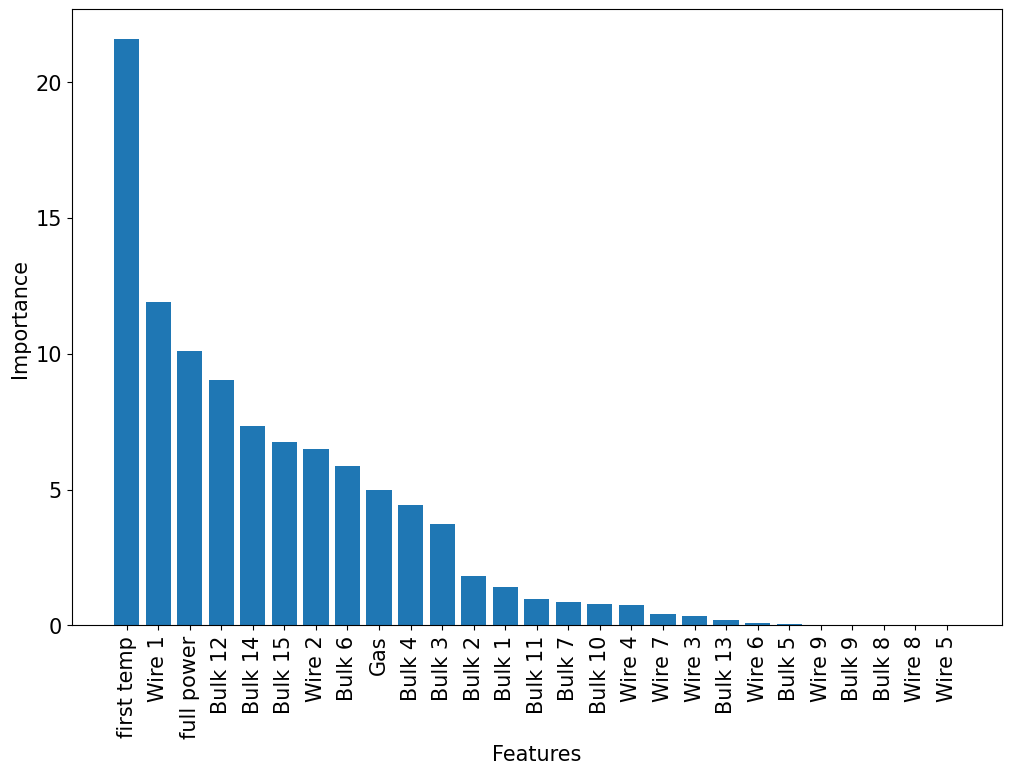

In [68]:
import catboost as cb

train_pool = cb.Pool(data=features_train, label=target_train)

regressor_CBR = cb.CatBoostRegressor()
regressor_CBR.fit(train_pool)
feat_importance = regressor_CBR.get_feature_importance(train_pool)

sorted_idx = np.argsort(feat_importance)[::-1]

# Построение графика значимости признаков
plt.figure(figsize=(12, 8))
plt.bar(range(features_train.shape[1]), feat_importance[sorted_idx])
plt.xticks(range(features_train.shape[1]), features_train.columns[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


Наиболее значимыми признакими при обучении модели являются начальная температура и полная мощность. Это может быть интерпретировано экспертами и использовано в качестве основы для сбора большего количества данных в будущем.

## Вывод: 

<b> Представленная модель может быть использована для оптимизации производственных расходов металлургического комбината ООО «Так закаляем сталь»